### Part One

In [325]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd
import json 
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import geocoder # import geocoder
import folium
from sklearn.cluster import KMeans
import json # library to handle JSON files
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.pyplot as plt


In [92]:
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)



200


In [93]:
soup = BeautifulSoup(response.text, 'html.parser')
canadatable=soup.find('table',{'class':"wikitable"})

In [94]:
df=pd.read_html(str(canadatable))
# convert list to dataframe
df=pd.DataFrame(df[0])
print(df.head())

  Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront


In [95]:
df = df.rename(columns={"Postal Code":"PostalCode"})
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [96]:
df["Borough"].value_counts()
#to check how many rows with a 'Not assigned' value.

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

In [97]:
df.shape

(180, 3)

In [98]:
canadadf = df[df['Borough'] == 'Not assigned'].index
 
# Delete these row indexes from dataFrame
df.drop(canadadf , inplace=True)
canadadf = df

In [99]:
canadadf.shape
#we can see that the 77 not assigned borough got erased. 

(103, 3)

### Canada Dataframe

In [100]:
canadadf.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Part Two

In [101]:
geolatlon= pd.read_csv("/Users/aymanamer/Downloads/Geospatial_Coordinates.csv")
geolatlon= pd.DataFrame(geolatlon)

geolatlon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [102]:
geolatlon.rename(columns={"Postal Code":"PostalCode"}, inplace=True)
geolatlon.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [103]:
canadamap= canadadf.merge(geolatlon, how='left', on=('PostalCode'))

In [104]:
canadamap.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Part Three

Before going further with the analysis it is better to know the dataframe we are working with in more details.

In [105]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(canadamap['Borough'].unique()),
        canadamap.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [106]:
latitude= 43.6532
longitude= -79.3832
map_canada = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(canadamap['Latitude'], canadamap['Longitude'], canadamap['Borough'], canadamap['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

In [107]:
etobicoke_data = canadamap[canadamap['Borough'] == 'Etobicoke'].reset_index(drop=True)
etobicoke_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
1,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724
2,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201
3,M9P,Etobicoke,Westmount,43.696319,-79.532242
4,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724


In [290]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.6534817, -79.3839347.


In [291]:
map_etobicoke = folium.Map(location=[etobicoke_lat, etobicoke_lon], zoom_start=11)

# add markers to map
for lat, lng, label in zip(etobicoke_data['Latitude'], etobicoke_data['Longitude'], etobicoke_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_etobicoke)  
    
map_etobicoke

After adding all the details of the area we are going to study, focusing only on one neighbourhood called Etobicoke, we will be using Foursquare API to fetch the data of nearby veneus.

In [292]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [293]:
etobicoke_data.loc[0, 'Neighbourhood']

'Islington Avenue, Humber Valley Village'

In [294]:
neighbourhood_latitude = etobicoke_data.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = etobicoke_data.loc[0, 'Longitude'] # neighborhood longitude value

neighbourhood_name = etobicoke_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Islington Avenue, Humber Valley Village are 43.6678556, -79.53224240000002.


In [295]:
LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 2000 # define radius



# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5XTFDVQMFVBSFAZSPQR113DGD5SNZZS5JVMNEFLVARPALJIL&client_secret=OFELZ0LXXYULOKOVYFL2SIVRUGMOJUKRBACCERCUSKPYI0WC&v=20180605&ll=43.6678556,-79.53224240000002&radius=2000&limit=100'

In [296]:
results = requests.get(url).json()

In [297]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [298]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns =['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


nearby_venues.head()





,name,categories,lat,lng
0,Java Joe's Village Cafe,Café,43.662461,-79.532054
1,St Georges Golf and Country Club,Golf Course,43.674395,-79.537142
2,"Ma Maison, Boulangerie - Patisserie - Traiteur",French Restaurant,43.659490,-79.513624
3,James Gardens Park,Garden,43.671256,-79.513338
4,Mastermind Toys,Toy / Game Store,43.659664,-79.513827


In [299]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

49 venues were returned by Foursquare.


In [300]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [301]:
etobicoke_venues = getNearbyVenues(names=etobicoke_data['Neighbourhood'],
                                   latitudes=etobicoke_data['Latitude'],
                                   longitudes=etobicoke_data['Longitude']
                                  )

Islington Avenue, Humber Valley Village
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Westmount
Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens
New Toronto, Mimico South, Humber Bay Shores
South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens
Alderwood, Long Branch
Northwest, West Humber - Clairville
The Kingsway, Montgomery Road, Old Mill North
Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West


In [302]:
print(etobicoke_venues.shape)
etobicoke_venues.head()

(449, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,Java Joe's Village Cafe,43.662461,-79.532054,Café
1,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,St Georges Golf and Country Club,43.674395,-79.537142,Golf Course
2,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,COBS Bread,43.664940,-79.520485,Bakery
3,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,TD Canada Trust,43.662545,-79.531749,Bank
4,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,Shoppers Drug Mart,43.663067,-79.531753,Pharmacy


In [303]:
etobicoke_venues.groupby('Neighborhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood, Long Branch",46,46,46,46,46,46
"Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood",38,38,38,38,38,38
"Islington Avenue, Humber Valley Village",18,18,18,18,18,18
"Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens",36,36,36,36,36,36
"Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West",71,71,71,71,71,71
"New Toronto, Mimico South, Humber Bay Shores",38,38,38,38,38,38
"Northwest, West Humber - Clairville",16,16,16,16,16,16
"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East",37,37,37,37,37,37
"South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens",32,32,32,32,32,32


In [304]:
print('There are {} uniques categories.'.format(len(etobicoke_venues['Venue Category'].unique())))

There are 119 uniques categories.


In [305]:
# one hot encoding
etobicoke_onehot = pd.get_dummies(etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
etobicoke_onehot['Neighbourhood'] = etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [etobicoke_onehot.columns[-1]] + list(etobicoke_onehot.columns[:-1])
etobicoke_onehot = etobicoke_onehot[fixed_columns]

etobicoke_onehot.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Video Game Store,Warehouse Store,Wings Joint,Yoga Studio
0,"Islington Avenue, Humber Valley Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Islington Avenue, Humber Valley Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Islington Avenue, Humber Valley Village",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Islington Avenue, Humber Valley Village",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Islington Avenue, Humber Valley Village",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [306]:
etobicoke_onehot.shape

(449, 120)

In [307]:
etobicoke_grouped = etobicoke_onehot.groupby('Neighbourhood').mean().reset_index()
etobicoke_grouped

,Neighbourhood,American Restaurant,Asian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Video Game Store,Warehouse Store,Wings Joint,Yoga Studio
0,"Alderwood, Long Branch",0.000000,0.000000,0.0000,0.000000,0.000000,0.021739,0.043478,0.021739,0.000000,...,0.000000,0.000000,0.043478,0.021739,0.000000,0.000000,0.021739,0.000000,0.021739,0.000000
1,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.052632,0.000000,0.131579,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Islington Avenue, Humber Valley Village",0.000000,0.000000,0.0000,0.000000,0.000000,0.055556,0.111111,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Kingsview Village, St. Phillips, Martin Grove ...",0.055556,0.000000,0.0000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000
4,"Mimico NW, The Queensway West, South of Bloor,...",0.000000,0.014085,0.0000,0.014085,0.028169,0.028169,0.042254,0.014085,0.000000,...,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.014085,0.028169
5,"New Toronto, Mimico South, Humber Bay Shores",0.026316,0.000000,0.0000,0.000000,0.000000,0.052632,0.026316,0.026316,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Northwest, West Humber - Clairville",0.062500,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.054054,0.027027,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"South Steeles, Silverstone, Humbergate, Jamest...",0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"The Kingsway, Montgomery Road, Old Mill North",0.015625,0.000000,0.0000,0.000000,0.000000,0.015625,0.046875,0.015625,0.000000,...,0.000000,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [308]:
etobicoke_grouped.shape

(12, 120)

In [309]:
num_top_venues = 5

for hood in etobicoke_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = etobicoke_grouped[etobicoke_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood, Long Branch----
         venue  freq
0  Coffee Shop  0.04
1         Park  0.04
2         Bank  0.04
3  Pizza Place  0.04
4   Restaurant  0.04


----Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood----
            venue  freq
0  Baseball Field  0.13
1     Coffee Shop  0.08
2  Sandwich Place  0.05
3     Pizza Place  0.05
4            Bank  0.05


----Islington Avenue, Humber Valley Village----
            venue  freq
0        Pharmacy  0.17
1            Bank  0.11
2   Shopping Mall  0.11
3  Ice Cream Shop  0.06
4        Bus Line  0.06


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                 venue  freq
0          Pizza Place  0.08
1          Coffee Shop  0.08
2             Pharmacy  0.08
3        Shopping Mall  0.06
4  Sporting Goods Shop  0.06


----Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West----
              venue  freq
0        Restaurant  0.13
1       Coffee Shop 

In [310]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [311]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = etobicoke_grouped['Neighbourhood']

for ind in np.arange(etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alderwood, Long Branch",Bank,Toy / Game Store,Park,Burger Joint,Restaurant,Coffee Shop,Grocery Store,Café,Pizza Place,Print Shop
1,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Baseball Field,Coffee Shop,Convenience Store,Sandwich Place,Bank,Grocery Store,Pizza Place,Park,Restaurant,Recreation Center
2,"Islington Avenue, Humber Valley Village",Pharmacy,Shopping Mall,Bank,Ice Cream Shop,Japanese Restaurant,Convenience Store,Café,Bus Line,Supermarket,Liquor Store
3,"Kingsview Village, St. Phillips, Martin Grove ...",Pharmacy,Pizza Place,Coffee Shop,American Restaurant,Bank,Beer Store,Sandwich Place,Shopping Mall,Liquor Store,Sporting Goods Shop
4,"Mimico NW, The Queensway West, South of Bloor,...",Restaurant,Coffee Shop,Bank,Sushi Restaurant,Yoga Studio,BBQ Joint,Bakery,Brewery,Burger Joint,Burrito Place


After knowing gathering enough data regarding the establishments around that area, it is time to cluster them and reflect that data on the map.

In [312]:
kclusters = 5

etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 1, 2, 2, 4, 2, 3, 2], dtype=int32)

In [313]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # add clustering labels

etobicoke_merged = etobicoke_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
etobicoke_merged = etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

etobicoke_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0,Pharmacy,Shopping Mall,Bank,Ice Cream Shop,Japanese Restaurant,Convenience Store,Café,Bus Line,Supermarket,Liquor Store
1,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,1,Park,Convenience Store,Grocery Store,Intersection,Pizza Place,Coffee Shop,Restaurant,Farmers Market,Sandwich Place,Fish & Chips Shop
2,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,1,Baseball Field,Coffee Shop,Convenience Store,Sandwich Place,Bank,Grocery Store,Pizza Place,Park,Restaurant,Recreation Center
3,M9P,Etobicoke,Westmount,43.696319,-79.532242,1,Pizza Place,Grocery Store,Restaurant,Coffee Shop,Bank,Pharmacy,Sandwich Place,Gym,Plaza,Park
4,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,1,Pharmacy,Pizza Place,Coffee Shop,American Restaurant,Bank,Beer Store,Sandwich Place,Shopping Mall,Liquor Store,Sporting Goods Shop


In [314]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(etobicoke_merged['Latitude'], etobicoke_merged['Longitude'], etobicoke_merged['Neighbourhood'], etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [315]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 0, etobicoke_merged.columns[[1] + list(range(5, etobicoke_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etobicoke,0,Pharmacy,Shopping Mall,Bank,Ice Cream Shop,Japanese Restaurant,Convenience Store,Café,Bus Line,Supermarket,Liquor Store


In [316]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 1, etobicoke_merged.columns[[1] + list(range(5, etobicoke_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Etobicoke,1,Park,Convenience Store,Grocery Store,Intersection,Pizza Place,Coffee Shop,Restaurant,Farmers Market,Sandwich Place,Fish & Chips Shop
2,Etobicoke,1,Baseball Field,Coffee Shop,Convenience Store,Sandwich Place,Bank,Grocery Store,Pizza Place,Park,Restaurant,Recreation Center
3,Etobicoke,1,Pizza Place,Grocery Store,Restaurant,Coffee Shop,Bank,Pharmacy,Sandwich Place,Gym,Plaza,Park
4,Etobicoke,1,Pharmacy,Pizza Place,Coffee Shop,American Restaurant,Bank,Beer Store,Sandwich Place,Shopping Mall,Liquor Store,Sporting Goods Shop


In [317]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 2, etobicoke_merged.columns[[1] + list(range(5, etobicoke_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Etobicoke,2,Park,Grocery Store,Café,Indian Restaurant,Bakery,American Restaurant,Pharmacy,Restaurant,Coffee Shop,Pub
7,Etobicoke,2,Bank,Toy / Game Store,Park,Burger Joint,Restaurant,Coffee Shop,Grocery Store,Café,Pizza Place,Print Shop
9,Etobicoke,2,Coffee Shop,Bank,Pub,Italian Restaurant,French Restaurant,Sushi Restaurant,Park,Restaurant,Liquor Store,Grocery Store
10,Etobicoke,2,Coffee Shop,Park,Italian Restaurant,Pizza Place,Restaurant,Sandwich Place,Bank,Sushi Restaurant,Chinese Restaurant,River
11,Etobicoke,2,Restaurant,Coffee Shop,Bank,Sushi Restaurant,Yoga Studio,BBQ Joint,Bakery,Brewery,Burger Joint,Burrito Place


In [318]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 3, etobicoke_merged.columns[[1] + list(range(5, etobicoke_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Etobicoke,3,Fast Food Restaurant,Coffee Shop,Grocery Store,Pizza Place,Sandwich Place,Caribbean Restaurant,Ice Cream Shop,Bus Line,Greek Restaurant,Indian Restaurant


In [319]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 4, etobicoke_merged.columns[[1] + list(range(5, etobicoke_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Etobicoke,4,Coffee Shop,American Restaurant,Casino,Gas Station,Mediterranean Restaurant,Moving Target,Paper / Office Supplies Store,Pizza Place,Department Store,Restaurant


In [285]:
! jupyter nbconvert --to html CanadaTable.ipynb

[NbConvertApp] Converting notebook CanadaTable.ipynb to html
[NbConvertApp] Writing 590923 bytes to CanadaTable.html


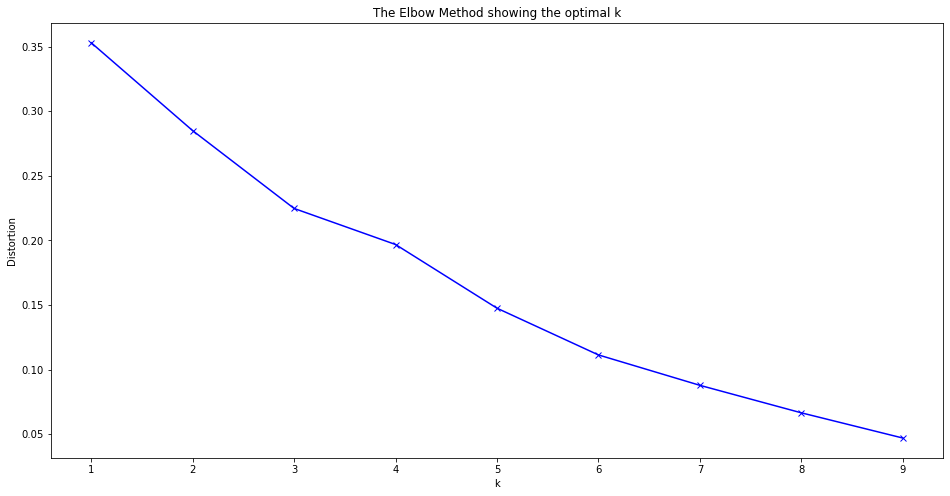

In [326]:

# run K-means with a range of k (elbow method)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(etobicoke_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

# plot the distortions of K
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()